<a href="https://colab.research.google.com/github/YoweioY/Product_demand_forecast/blob/master/product_demand_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import statistics
import math

import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

#for LSTM model
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #連結google drive
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Historical Product Demand.csv')
data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50


In [ ]:
# # 检测本机是否安装GPU
# use_gpu = False
# gpu_num = 0

# if tf.config.experimental.list_physical_devices('GPU'):
#     use_gpu = True
#     gpu_devices = tf.config.experimental.list_physical_devices('GPU')
#     gpu_num = len(gpu_devices)
#     gpu_device_index = 0  # 选择第一个GPU，根据需要进行修改

# device = tf.device('/GPU:' + str(gpu_device_index) if use_gpu else '/CPU:0')

In [ ]:
# check the null data
data.isna().sum()

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64

In [ ]:
# drop the missing values, we can not fill the date so best way drop missing samples
data.dropna(inplace=True)

# check the null data again
data.isnull().sum()

Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64

In [ ]:
# sort the data according yo date column
data.sort_values('Date', ignore_index=True, inplace=True)
data.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0965,Whse_A,Category_006,2011/1/8,2
1,Product_0412,Whse_S,Category_007,2011/10/20,(2)
2,Product_0125,Whse_S,Category_011,2011/10/20,(2)
3,Product_0642,Whse_C,Category_019,2011/10/31,3
4,Product_2137,Whse_S,Category_009,2011/11/18,(25)


In [ ]:
# there are () int the OrderDemand column and we need to remove them
data['Order_Demand'] = data['Order_Demand'].str.replace('(',"")
data['Order_Demand'] = data['Order_Demand'].str.replace(')',"")

# change the dtype as int64
data['Order_Demand'] = data['Order_Demand'].astype('int64')

In [ ]:
# creating Year, Month, Day field for further analysis

# first way
# data[["Year", "Month", "Day"]] = data["Date"].str.split("/", expand = True)
# data

# second way change date columns dtype as datetime
from datetime import datetime as dt

# convert the 'Date' column to datetime format
data['Date']= pd.to_datetime(data['Date'])

# create Year, Month, Day columns
data['Year'] = data["Date"].dt.year
data['Month'] = data["Date"].dt.month
data['Day'] = data["Date"].dt.day

In [ ]:
# information about data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037336 entries, 0 to 1037335
Data columns (total 8 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Product_Code      1037336 non-null  object        
 1   Warehouse         1037336 non-null  object        
 2   Product_Category  1037336 non-null  object        
 3   Date              1037336 non-null  datetime64[ns]
 4   Order_Demand      1037336 non-null  int64         
 5   Year              1037336 non-null  int64         
 6   Month             1037336 non-null  int64         
 7   Day               1037336 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 63.3+ MB


In [ ]:
data.head(10)

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Year,Month,Day
0,Product_0965,Whse_A,Category_006,2011-01-08,2,2011,1,8
1,Product_0412,Whse_S,Category_007,2011-10-20,2,2011,10,20
2,Product_0125,Whse_S,Category_011,2011-10-20,2,2011,10,20
3,Product_0642,Whse_C,Category_019,2011-10-31,3,2011,10,31
4,Product_2137,Whse_S,Category_009,2011-11-18,25,2011,11,18
5,Product_0288,Whse_S,Category_021,2011-11-18,50,2011,11,18
6,Product_0131,Whse_S,Category_021,2011-11-18,12,2011,11,18
7,Product_2138,Whse_S,Category_009,2011-11-18,49,2011,11,18
8,Product_2143,Whse_S,Category_009,2011-11-18,25,2011,11,18
9,Product_0980,Whse_A,Category_028,2011-11-18,4000,2011,11,18


In [ ]:
# statistical information about OrderDemand
data["Order_Demand"].describe()

count    1.037336e+06
mean     4.949384e+03
std      2.907344e+04
min      0.000000e+00
25%      2.000000e+01
50%      3.000000e+02
75%      2.000000e+03
max      4.000000e+06
Name: Order_Demand, dtype: float64

In [ ]:
# information about categorical variables
data[["Product_Code", "Warehouse", "Product_Category"]].describe()

,Product_Code,Warehouse,Product_Category
count,1037336,1037336,1037336
unique,2160,4,33
top,Product_1359,Whse_J,Category_019
freq,16936,764447,470266


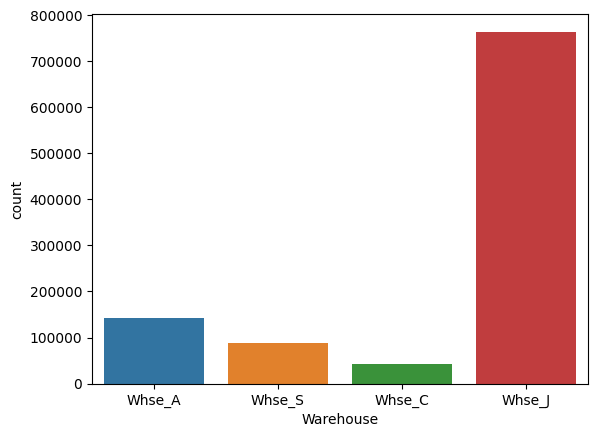

Number of samples according to Warehouse 
Whse_J    764447
Whse_A    142335
Whse_S     88200
Whse_C     42354
Name: Warehouse, dtype: int64


In [ ]:
# Number of samples according to Warehouse
sns.countplot(x="Warehouse", data=data)
plt.xticks(rotation = 0)
plt.show()
print(f"Number of samples according to Warehouse \n{data['Warehouse'].value_counts()}")

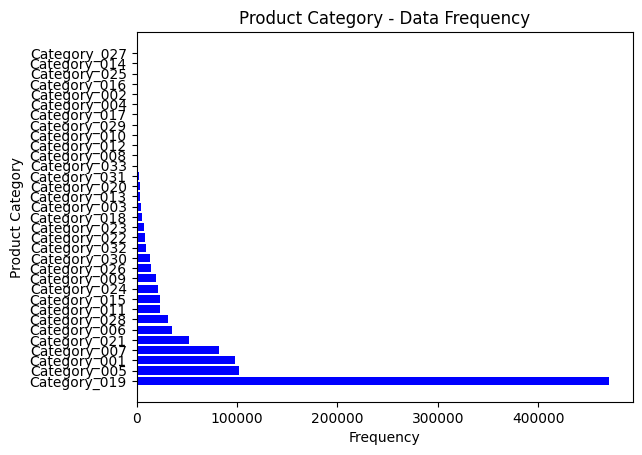

Number of ProductCategory 
Category_019    470266
Category_005    101627
Category_001     97787
Category_007     82402
Category_021     52008
Category_006     35552
Category_028     31012
Category_011     23208
Category_015     22954
Category_024     20885
Category_009     19738
Category_026     14771
Category_030     12997
Category_032      9296
Category_022      8657
Category_023      7899
Category_018      5239
Category_003      4189
Category_013      3743
Category_020      3490
Category_031      2268
Category_033      1849
Category_008      1560
Category_012      1147
Category_010       976
Category_029       671
Category_017       615
Category_004       329
Category_002        77
Category_016        37
Category_025        35
Category_014        26
Category_027        26
Name: Product_Category, dtype: int64


In [ ]:
# Number of samples according to ProductCategory
plt.figure()
plt.barh(data["Product_Category"].value_counts().index, data["Product_Category"].value_counts(), color = "b")
plt.xlabel("Frequency")
plt.ylabel("Product Category")
plt.title("Product Category - Data Frequency")
plt.show()
print(f"Number of ProductCategory \n{data['Product_Category'].value_counts()}")

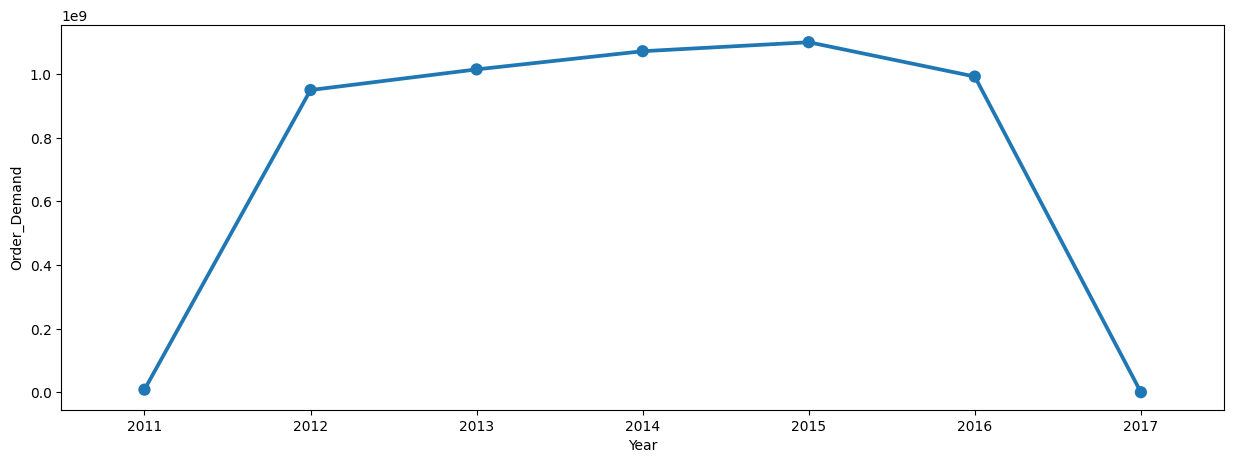

In [ ]:
df = data[['Order_Demand', 'Year']].groupby(["Year"]).sum().reset_index().sort_values(by='Year', ascending=False)
f, ax=plt.subplots(figsize=(15, 5))
sns.pointplot(x='Year', y='Order_Demand', data=df)
plt.show()

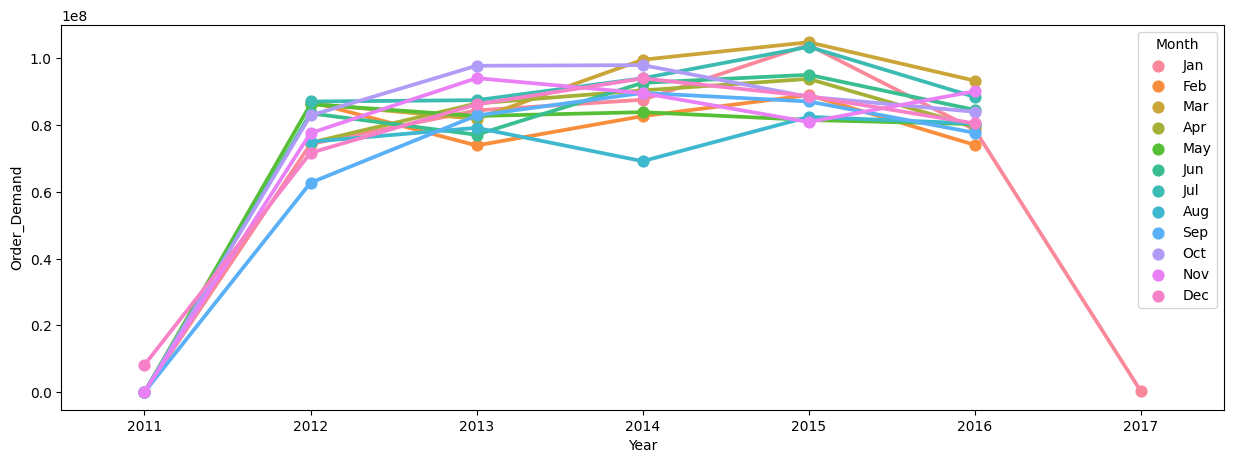

In [ ]:
temp_data = data.copy()
temp_data.Month.replace([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan', 'Feb', 'Mar', 'Apr', 'May','Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], inplace=True)
df = temp_data[['Order_Demand','Month', 'Year',]].groupby(["Year","Month"]).sum().reset_index().sort_values(by=['Year','Month'], ascending=False)
f, ax = plt.subplots(figsize=(15, 5))
sns.pointplot(x='Year', y='Order_Demand', data=df, hue='Month', hue_order=['Jan', 'Feb', 'Mar', 'Apr', 'May','Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

In [ ]:
df = (df.pivot(index='Year', columns='Month', values='Order_Demand'))
df = df.loc[:, ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
df

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2011,2.0,NaN,NaN,NaN,108.0,92000.0,NaN,NaN,6728.0,7.0,86524.0,8178525.0
2012,74331037.0,86951780.0,86463212.0,74714053.0,86246051.0,83521679.0,87071567.0,75003241.0,62748329.0,82891675.0,77618687.0,71698680.0
2013,84399001.0,73899741.0,81857480.0,86489453.0,82735797.0,77115902.0,87469057.0,79181220.0,82882856.0,97773582.0,94072859.0,86210974.0
2014,87593983.0,82688430.0,99580627.0,90391888.0,83876775.0,92655892.0,94023350.0,69199733.0,89629088.0,97963491.0,89572680.0,94002430.0
2015,104028474.0,88991822.0,104825197.0,93842250.0,81540033.0,95074257.0,103449803.0,82468895.0,87080162.0,88477211.0,80944042.0,88676245.0
2016,78627619.0,74065041.0,93303910.0,79503364.0,80299593.0,84553011.0,88439936.0,80471772.0,77698896.0,84000757.0,90128568.0,80497932.0
2017,294967.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 檢查月分實際需求量資料筆數
filtered_data = data[(data['Year'] == 2012) & (data['Month'] == 1)]
len(filtered_data)

15614

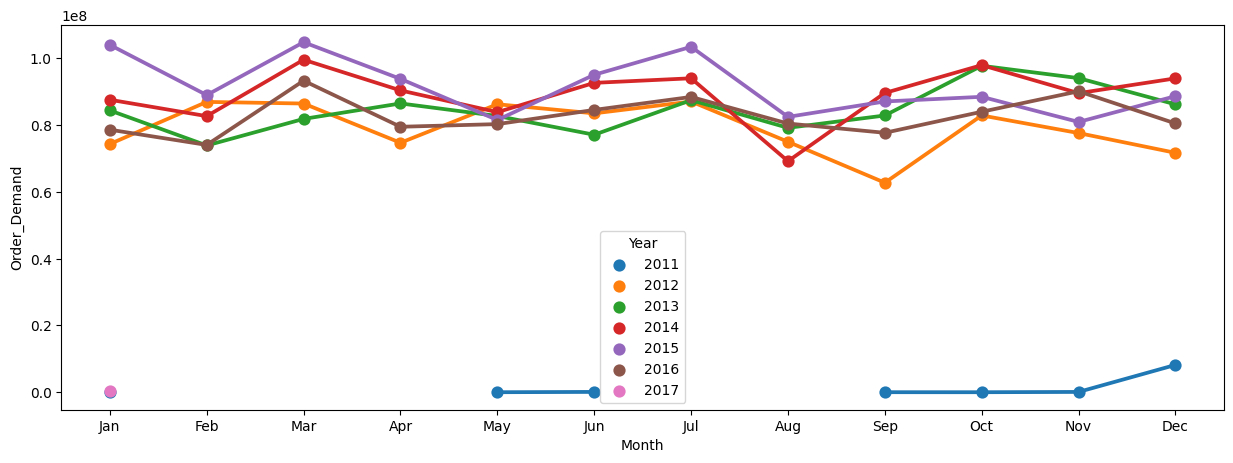

In [ ]:
custom_dict = {'Jan':0, 'Feb':1, 'Mar':2, 'Apr':3, 'May':4, 'Jun':5,
               'Jul':6, 'Aug':7, 'Sep':8, 'Oct':9, 'Nov':10, 'Dec':11}
temp_data = data.copy()
temp_data.Month.replace([1,2,3,4,5,6,7,8,9,10,11,12], ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], inplace=True)
df = temp_data[["Order_Demand", 'Month', 'Year']].groupby(["Year","Month"]).sum().reset_index().sort_values(by=['Year','Month'], ascending=True)
df = df.iloc[df['Month'].map(custom_dict).argsort()]
f, ax = plt.subplots(figsize=(15, 5))
sns.pointplot(x='Month', y="Order_Demand", data=df, hue="Year")
plt.show()

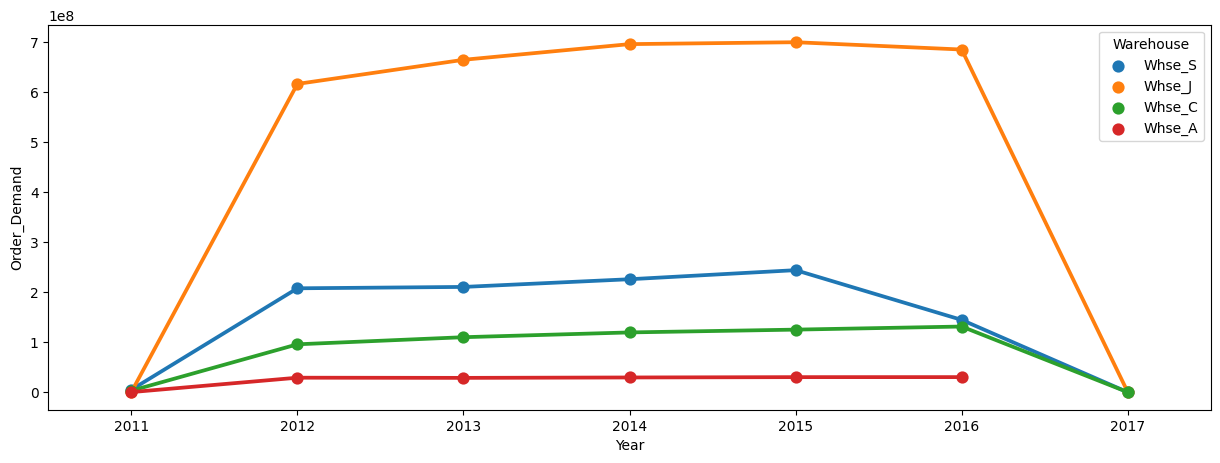

In [ ]:
# Warehouse Based Analysis
df = data[["Order_Demand", 'Year', 'Warehouse']].groupby(["Year","Warehouse"]).sum().reset_index().sort_values(by=['Warehouse','Year'], ascending=False)
f, ax=plt.subplots(figsize=(15, 5))
sns.pointplot(x='Year', y="Order_Demand", data=df, hue="Warehouse")
plt.show()

In [ ]:
df = (df.pivot(index='Year', columns='Warehouse', values='Order_Demand'))
df

Warehouse,Whse_A,Whse_C,Whse_J,Whse_S
Year,,,,
2011,230881.0,3031847.0,198547.0,4902619.0
2012,29048000.0,95823181.0,616560449.0,207828361.0
2013,28696890.0,110035879.0,664781670.0,210573483.0
2014,29507380.0,119583036.0,696130811.0,225957140.0
2015,30167990.0,125188986.0,699932604.0,244108811.0
2016,30226290.0,131373097.0,685336996.0,144654016.0
2017,NaN,35378.0,259319.0,270.0


In [ ]:
# Product Category Based Analysis
df = data[["Order_Demand",'Product_Category', 'Warehouse']].groupby(["Product_Category","Warehouse"]).sum().reset_index().sort_values(by=['Order_Demand'],ascending=False)
df = df.pivot(index='Product_Category', columns='Warehouse', values='Order_Demand')
df

Warehouse,Whse_A,Whse_C,Whse_J,Whse_S
Product_Category,,,,
Category_001,1749.0,60106.0,1.623054e+06,72564.0
Category_002,NaN,NaN,NaN,628.0
Category_003,131607.0,NaN,3.926700e+04,222076.0
Category_004,NaN,NaN,NaN,99046.0
Category_005,1124300.0,12528700.0,1.289245e+08,57097050.0
Category_006,11613427.0,33131500.0,3.187667e+08,42059693.0
Category_007,2839680.0,7179524.0,1.121572e+08,6515085.0
Category_008,1903.0,317.0,1.534800e+04,NaN
Category_009,920903.0,251031.0,4.464690e+05,2163738.0


In [ ]:
df = data[["Order_Demand",'Product_Category', 'Year']].groupby(["Product_Category","Year"]).sum().reset_index().sort_values(by=['Order_Demand'],ascending=False)
df = df.pivot(index='Product_Category', columns='Year', values='Order_Demand')
df

Year,2011,2012,2013,2014,2015,2016,2017
Product_Category,,,,,,,
Category_001,997.0,275607.0,320250.0,369620.0,389403.0,401567.0,29.0
Category_002,NaN,NaN,201.0,204.0,223.0,NaN,NaN
Category_003,1708.0,75056.0,92937.0,82232.0,94320.0,46697.0,NaN
Category_004,2780.0,23810.0,26401.0,25176.0,20879.0,NaN,NaN
Category_005,673750.0,35198945.0,36201555.0,43707445.0,45454520.0,38427705.0,10600.0
Category_006,490509.0,67259055.0,81419576.0,81544531.0,92122245.0,82665414.0,70000.0
Category_007,28564.0,24717088.0,28037572.0,27132962.0,25740371.0,23032502.0,2472.0
Category_008,NaN,3680.0,2826.0,3544.0,4341.0,3177.0,NaN
Category_009,1577.0,747277.0,840534.0,825505.0,903441.0,463807.0,NaN


In [ ]:
# for better results use the data between 2012-01-01 and 2016-12-31
df = data[(data['Date']>='2012-01-01') & (data['Date']<='2016-12-31')].sort_values('Date', ascending=True)
df = df.groupby('Date')['Order_Demand'].sum().reset_index()
df

,Date,Order_Demand
0,2012-01-01,2
1,2012-01-02,680277
2,2012-01-03,1645257
3,2012-01-04,1295861
4,2012-01-05,8941774
...,...,...
1676,2016-12-26,3628370
1677,2016-12-27,1674226
1678,2016-12-28,2740302
1679,2016-12-29,530487


In [ ]:
# for better results use the data between 2012-01-01 and 2016-12-31
data_all = data[(data['Date']>='2012-01-01') & (data['Date']<='2016-12-31')].sort_values('Date', ascending=True)
data_all = data_all.reset_index(drop=True)

In [ ]:
data_all

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Year,Month,Day
0,Product_2166,Whse_S,Category_024,2012-01-01,2,2012,1,1
1,Product_1342,Whse_S,Category_019,2012-01-02,30000,2012,1,2
2,Product_0381,Whse_S,Category_030,2012-01-02,1000,2012,1,2
3,Product_1341,Whse_S,Category_019,2012-01-02,13000,2012,1,2
4,Product_1264,Whse_S,Category_019,2012-01-02,2000,2012,1,2
...,...,...,...,...,...,...,...,...
1036638,Product_0033,Whse_S,Category_005,2016-12-30,30000,2016,12,30
1036639,Product_0427,Whse_A,Category_019,2016-12-30,5000,2016,12,30
1036640,Product_1388,Whse_A,Category_019,2016-12-30,100,2016,12,30
1036641,Product_1461,Whse_A,Category_019,2016-12-30,1000,2016,12,30


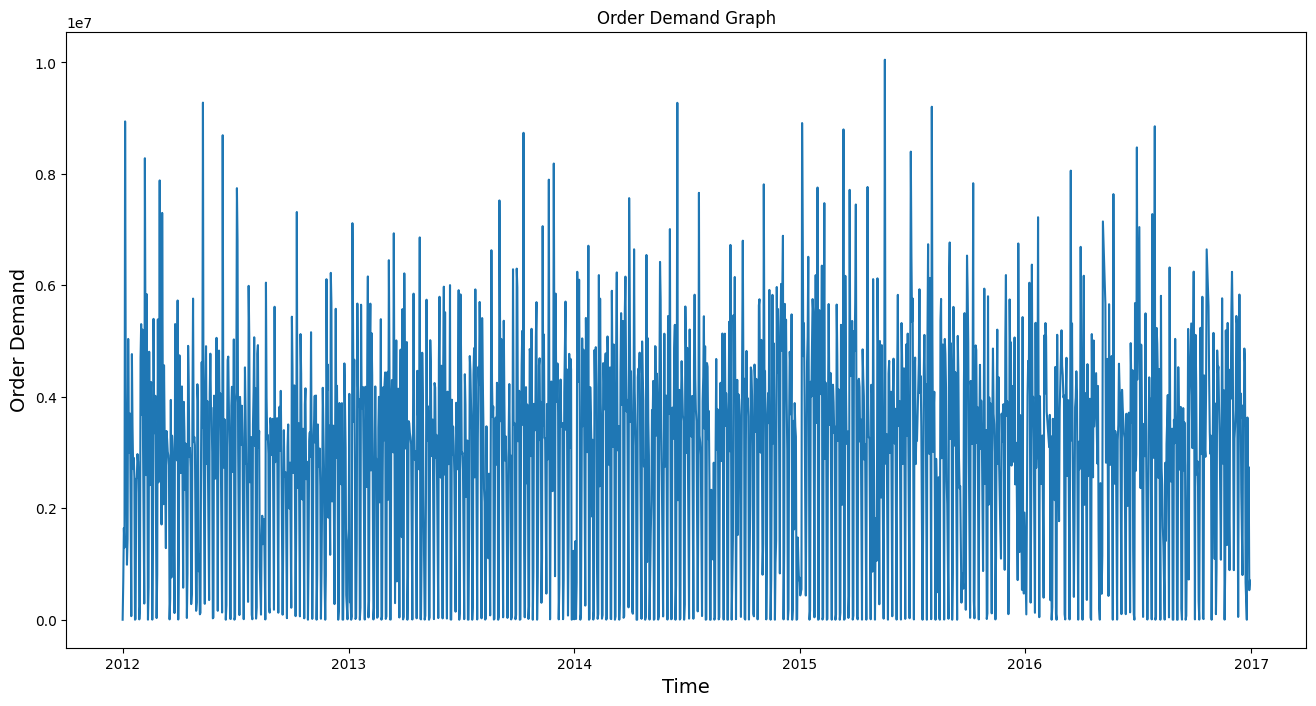

In [ ]:
# Visualize the order demand as time series
plt.figure(figsize=(16, 8))
plt.title("Order Demand Graph")
plt.plot(df["Date"], df["Order_Demand"])
plt.xlabel("Time", fontsize=14,)
plt.ylabel("Order Demand", fontsize=14)
plt.show()

In [ ]:
# 寫csv出去
# df.to_csv('/content/drive/MyDrive/AI_digital/第四組報告/祐瑋/orderdemand.csv', index=False)
#data_all.to_csv('/content/drive/MyDrive/AI_digital/第四組報告/祐瑋/all.csv', index=False)

In [ ]:
# Create new data with only the "OrderDemand" column
orderD = df.filter(["Order_Demand"])
# Convert the dataframe to a np array
orderD_array = orderD.values
# See the train data len
train_close_len = math.ceil(len(orderD_array) * 0.8)
train_close_len

1345

In [ ]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(orderD_array)
scaled_data

array([[1.99031453e-07],
       [6.76982600e-02],
       [1.63728946e-01],
       ...,
       [2.72703145e-01],
       [5.27917993e-02],
       [6.99545800e-02]])

In [ ]:
# Create the training dataset
train_data = scaled_data[0 : train_close_len, :]
# Create X_train and y_train
X_train = []
y_train = []
for i in range(180, len(train_data)):
    X_train.append(train_data[i - 180 : i, 0])
    y_train.append(train_data[i, 0])
    if i <= 180:
        print(X_train)
        print(y_train)

[array([1.99031453e-07, 6.76982600e-02, 1.63728946e-01, 1.28958549e-01,
       8.89847137e-01, 4.36947184e-01, 9.82368500e-02, 1.43570443e-01,
       5.01388891e-01, 3.30568853e-01, 2.98325061e-01, 3.68113549e-01,
       6.39388544e-03, 4.74326585e-01, 3.44696702e-01, 2.69870529e-01,
       2.89035666e-01, 2.55127374e-01, 1.99031453e-05, 1.34953277e-03,
       2.51593073e-01, 2.53474816e-01, 2.95791390e-01, 2.81800375e-01,
       2.26411613e-01, 6.16997505e-04, 2.32949398e-02, 4.68048834e-01,
       5.27871021e-01, 3.66383269e-01, 5.18157490e-01, 3.13818067e-01,
       2.88706070e-02, 8.24073013e-01, 4.73426465e-01, 2.58256546e-01,
       5.81354156e-01, 3.14602052e-01, 9.95157266e-05, 5.74927232e-02,
       4.78518585e-01, 2.40411486e-01, 3.48965828e-01, 4.24549316e-01,
       2.88825090e-01, 1.69176735e-04, 1.26577138e-01, 5.37255155e-01,
       3.60979068e-01, 3.33127004e-01, 3.99856478e-01, 1.72541561e-01,
       2.98547180e-03, 8.14840741e-02, 5.36301397e-01, 2.45390755e-01,
     

In [ ]:
#  make X_train and y_train np array
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
y_train.shape

(1165,)

In [ ]:
# reshape the data
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1165, 180, 1)

In [ ]:
# create the testing dataset
test_data = scaled_data[train_close_len - 180 : , :]
# create X_test and y_test
X_test = []
y_test = scaled_data[train_close_len : , :]
for i in range(180, len(test_data)):
    X_test.append(test_data[i - 180 : i, 0])

In [ ]:
# convert the test data to a np array and reshape the test data
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
X_test.shape

(336, 180, 1)

In [ ]:
# Build the LSTM Model
model = Sequential()

model.add(LSTM(units=512, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], 1)))

model.add(LSTM(units=256, activation='relu', return_sequences=False))

model.add(Dense(units=1))

In [ ]:
# compile the LSTM model
model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mae'])

In [ ]:
# train the LSTM model
model.fit(X_train, y_train,
          epochs=3,
          batch_size=100,
          verbose=1)

Epoch 1/3
12/12 [==============================] - 79s 6s/step - loss: 0.0756 - mae: 0.2289
Epoch 2/3
12/12 [==============================] - 74s 6s/step - loss: 0.0510 - mae: 0.1891
Epoch 3/3
12/12 [==============================] - 73s 6s/step - loss: 0.0421 - mae: 0.1705


In [ ]:
# predict with LSTM model
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

11/11 [==============================] - 9s 762ms/step


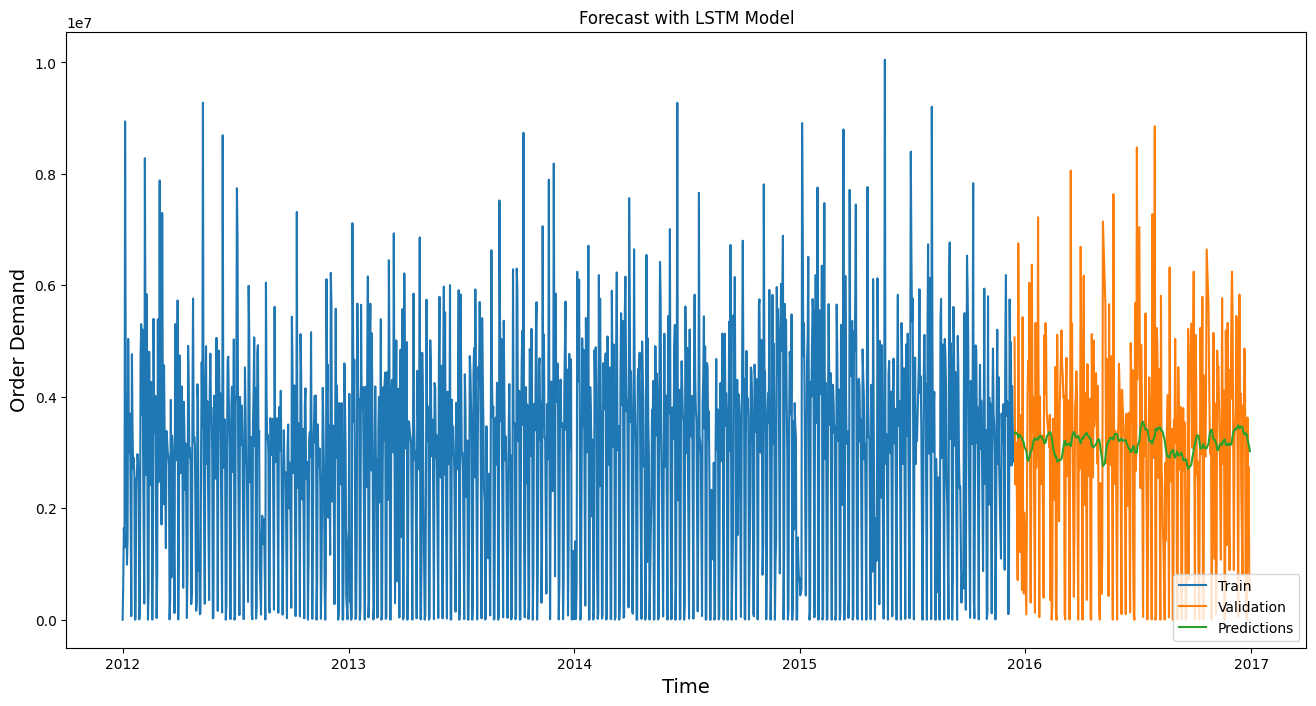

In [ ]:
# plot the data
train = orderD[:train_close_len]
valid = orderD[train_close_len:]
valid["Predictions"] = predictions
#visualize the data
plt.figure(figsize=(16, 8))
plt.title("Forecast with LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("Order Demand", fontsize=14)
plt.plot(df["Date"][:train_close_len], train["Order_Demand"])
plt.plot(df["Date"][train_close_len:], valid[["Order_Demand", "Predictions"]])
plt.legend(["Train", "Validation", "Predictions"], loc="lower right")
plt.show()

In [ ]:
# change the parameters of first LSTM model and build the Optimized LSTM Model
optimized_model = Sequential()

optimized_model.add(LSTM(1024, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], 1)))

# optimized_model.add(LSTM(512, activation='relu', return_sequences=True))

# optimized_model.add(LSTM(256, activation='relu', return_sequences=True))

optimized_model.add(LSTM(256, activation='relu', return_sequences=False))

optimized_model.add(Dense(64))


optimized_model.add(Dense(1))

In [ ]:
optimized_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 180, 1024)         4202496   
                                                                 
 lstm_5 (LSTM)               (None, 256)               1311744   
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5530753 (21.10 MB)
Trainable params: 5530753 (21.10 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# compile the model
optimized_model.compile(optimizer="Adam", loss="mean_squared_error", metrics=['mae'])

In [ ]:
#將訓練的模型置放於model_path下的model_name
model_name = 'lstm model6'



save_dir = os.path.join(os.getcwd(), 'saved_models')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name)

In [ ]:
#設定模型存放方式(只存Validation表現最好的那一次)
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, monitor = 'val_loss', save_best_only = True, verbose = 1)

#設定多久沒進步就停下來
earlystop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1)

In [ ]:
# train the optimized model
history = optimized_model.fit(X_train, y_train,
          batch_size=32,
          validation_split=0.1,
          epochs=30,
          callbacks=[earlystop, checkpoint],
          verbose=1)

Epoch 1/30
33/33 [==============================] - ETA: 0s - loss: 0.0502 - mae: 0.1799 
Epoch 1: val_loss improved from inf to 0.03811, saving model to /content/saved_models/lstm model6
33/33 [==============================] - 423s 13s/step - loss: 0.0502 - mae: 0.1799 - val_loss: 0.0381 - val_mae: 0.1554
Epoch 2/30
33/33 [==============================] - ETA: 0s - loss: 0.0421 - mae: 0.1673 
Epoch 2: val_loss improved from 0.03811 to 0.03643, saving model to /content/saved_models/lstm model6
33/33 [==============================] - 410s 12s/step - loss: 0.0421 - mae: 0.1673 - val_loss: 0.0364 - val_mae: 0.1543
Epoch 3/30
33/33 [==============================] - ETA: 0s - loss: 0.0419 - mae: 0.1656 
Epoch 3: val_loss did not improve from 0.03643
33/33 [==============================] - 394s 12s/step - loss: 0.0419 - mae: 0.1656 - val_loss: 0.0391 - val_mae: 0.1685
Epoch 4/30
33/33 [==============================] - ETA: 0s - loss: 0.0415 - mae: 0.1664 
Epoch 4: val_loss improved fro

In [ ]:
mae = mean_absolute_error(y_test, optimized_model.predict(X_test))
mse = mean_squared_error(y_test, optimized_model.predict(X_test))

print("Validation MAE:", mae)
print("Validation MSE:", mse)

11/11 [==============================] - 21s 2s/step
Validation MAE: 0.15130836094635725
Validation MSE: 0.03899141223754414


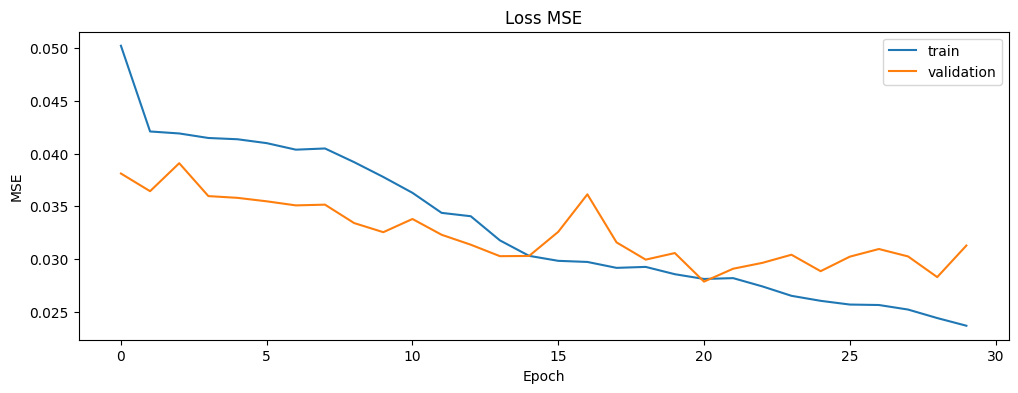

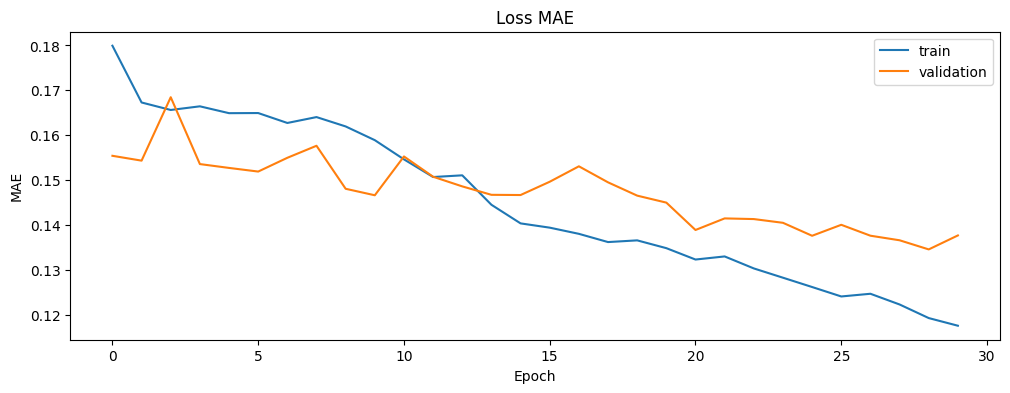

In [ ]:
# 繪製 loss 曲線
plt.figure(figsize=(12, 4))
# plt.subplot(1,2,1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()
# 繪製 mae 曲線
plt.figure(figsize=(12, 4))
# plt.subplot(1,2,2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Loss MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:

# Predict with optimized LSTM model
o_predictions = optimized_model.predict(X_test)
o_predictions = scaler.inverse_transform(o_predictions)

11/11 [==============================] - 22s 2s/step


In [ ]:
_, test_acc = optimized_model.evaluate(X_test, y_test, verbose=1)
print(test_acc)

11/11 [==============================] - 24s 2s/step - loss: 0.0390 - mae: 0.1513
0.1513083577156067


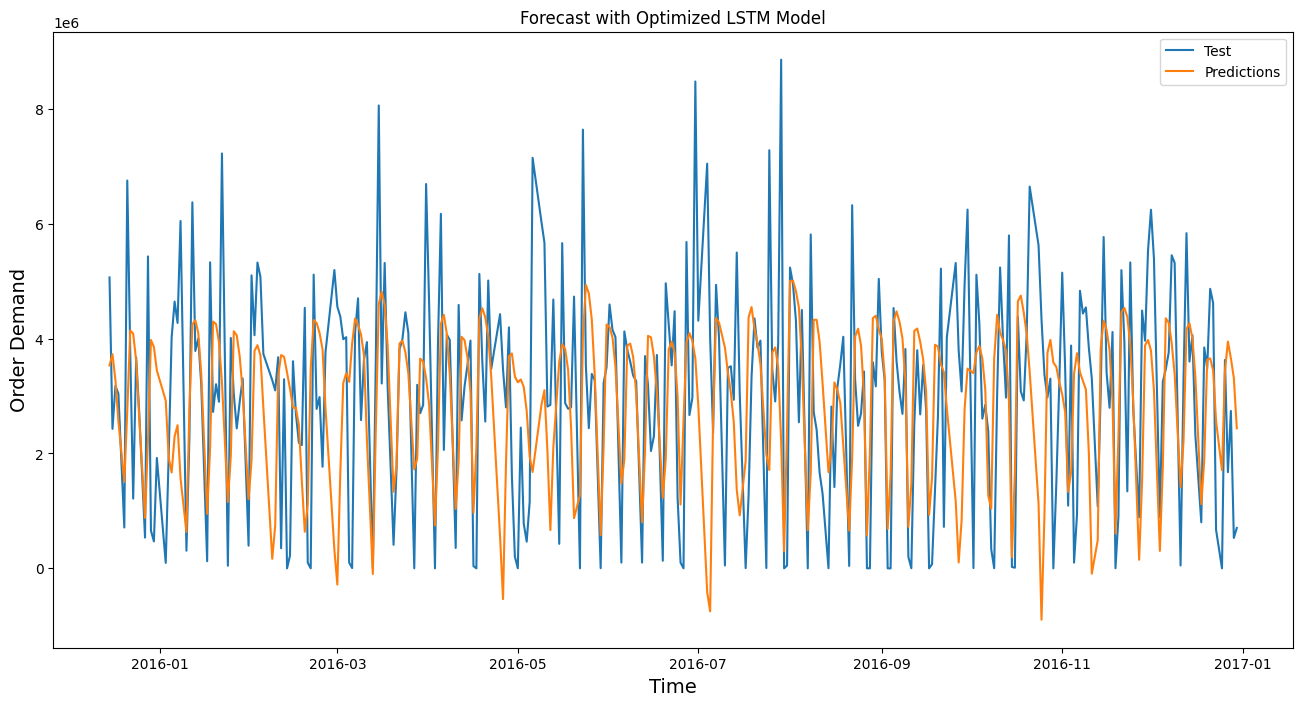

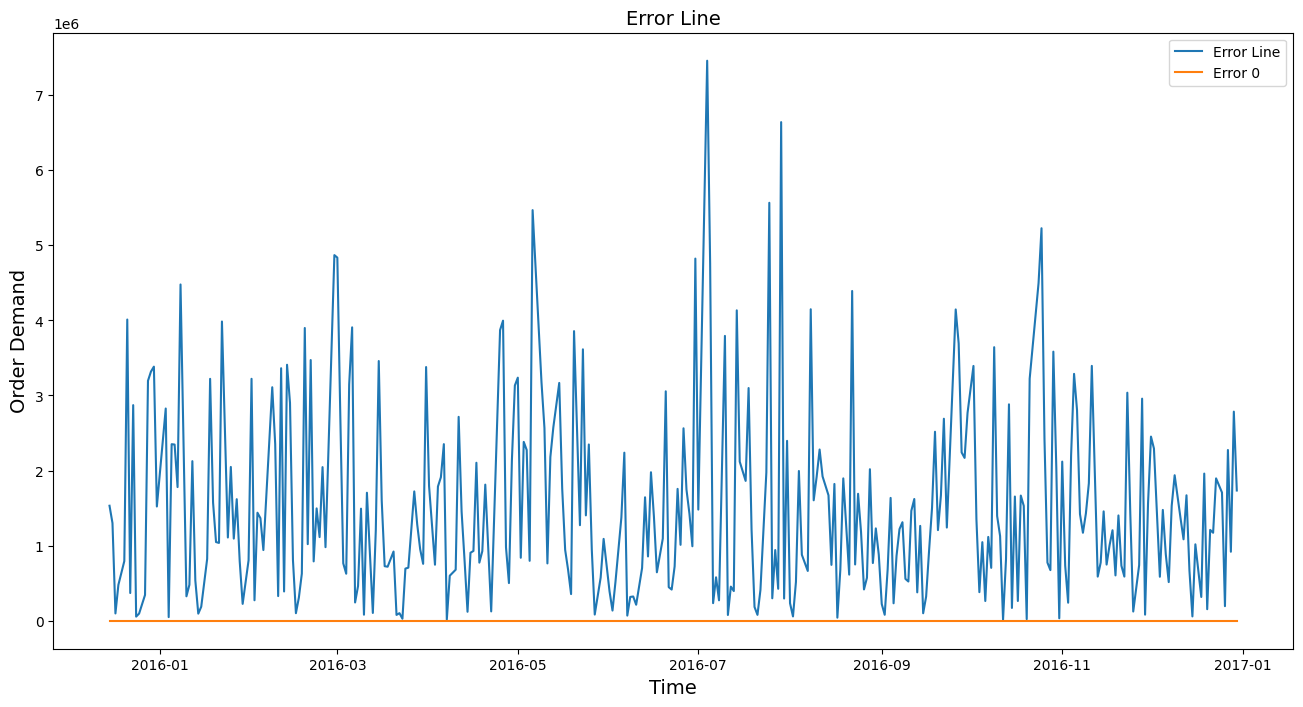

In [ ]:
# plot the data
# train = orderD[:train_close_len]
test = orderD[train_close_len:]
test["Predictions"] = o_predictions
#visualize the data
plt.figure(figsize=(16, 8))
plt.title("Forecast with Optimized LSTM Model")
plt.xlabel("Time", fontsize=14)
plt.ylabel("Order Demand", fontsize=14)
# plt.plot(df["Date"][:train_close_len], train["Order_Demand"])
plt.plot(df["Date"][train_close_len:], test[["Order_Demand", "Predictions"]])
plt.legend(["Test", "Predictions"], loc="upper right")
plt.show()


# 畫誤差變化圖
plt.figure(figsize=(16,8))
plt.title("Error Line", fontsize=14)
plt.plot(df["Date"][train_close_len:],abs(test-o_predictions))
# plt.ylim(-10,250)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Order Demand", fontsize=14)
plt.legend(["Error Line", "Error 0"], loc="upper right")
plt.show()


In [ ]:
print(mae)
print(mse)

0.15130836094635725
0.03899141223754414


In [ ]:
 # 產品固定19、倉庫看有沒有需要固定
# 有沒有需要預測時間間隔
# epoch大小
# learning rate大小
# 調整神經數與層數方法
# 存模型、設停損點
# mae、mse、mape
# 不要加起來直接丟
# randomstate